In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import mnist
import copy as copy
import matplotlib.gridspec as gridspec
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.set_cmap('jet')

In [47]:
# data loading function
def load_dataset():
    mndata = mnist.MNIST('./python-mnist/data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0

    labels_train = labels_train.astype('int')
    labels_test = labels_test.astype('int')
    return X_train, X_test,labels_train,labels_test

# kmeans functions
def init_random_k_clusters(k,data):
    rand_centers = np.random.randint(low = 0,high=data.shape[0]-1,size = k)
    centroids = data[rand_centers,:]
    return centroids

def calculate_distances_kplusplus(x_1,x_2):
    distances = scipy.linalg.norm(x_1-x_2,axis=1)**2
    return distances

def prob_dist(distances):
    total = np.sum(distances)
    probs = np.array([distance_ind/total for distance_ind in distances])
    return probs

def sample_dist(probs):
    center = np.random.choice(np.arange(probs.shape[0]),1,p=probs)
    return center

def k_plusplus(k,data):
    centroids = np.zeros((k,784))


    for i in np.arange(k):
        if i == 0:
            index_int = np.random.randint(0,data.shape[0])
            centroids[i,:] = data[index_int,:]   
        else:
            distances_array = np.zeros(i,data.shape[0])
            for j in np.arange(i):
                distances_array[j,:] = calculate_distances_kplusplus(centroids[j,:],data)
                
            min_dist = np.min(distances_array,axis=0)
            probs = prob_dist(min_dist)
            sample_dist = sample_dist(probs)
            centroids[i,:] = 
    
    return centroids 

def visualize_image(vector):
    #plt.figure()
    interp_method = 'bicubic'
    single_image = np.reshape(vector,[28,28])
    plt.imshow(single_image,interpolation=interp_method)
    plt.grid(False)
    plt.axis('off')
    
# cost function
def plt_cost_func_kmeans(iteration,cost,k):
    plt.figure(dpi=600)    
    plt.xlabel('iteration')
    plt.ylabel('cost')
    plt.title('iteration vs cost for k = {}'.format(k))
    plt.plot(iteration,cost)
    plt.savefig('iter_vs_cost_k_{}'.format(k))
    
def cost_func(centroids,data,data_labels):
    
    cost_array = np.zeros((centroids.shape[0],))
    
    for i in np.arange(centroids.shape[0]):
        row = np.where(data_labels==i)[0]    
        
        if len(row)!=0:
            data_sel = np.squeeze(data[row[:,np.newaxis],:])
            data_mean = np.mean(data_sel,axis=0)
            
            if len(row) != 1:
                normed_cost = np.sum(scipy.linalg.norm(data_sel-data_mean,axis=1)**2)
            else:
                normed_cost = np.sum(scipy.linalg.norm(data_sel-data_mean)**2)

            #import pdb;pdb.set_trace()
            cost_array[i] = normed_cost
        
    cost = np.sum(cost_array)

    return cost

def k_means_distance(centroids,data):
    
    data_labels = np.zeros((data.shape[0],1))
    
    for i in np.arange(data.shape[0]):
        dist_vec = np.zeros(centroids.shape[0])

        for j in np.arange(centroids.shape[0]):
            dist_vec[j] = np.sqrt(np.sum((centroids[j,:]-data[i,:])**2))
            
        best_centroid = np.argmin(dist_vec)
        data_labels[i] = best_centroid
        
    return data_labels

def k_means_centroid_update(centroids,data,data_labels):
    centroids_new = np.zeros((centroids.shape))
    had_to_randomize = False
    
    for i in np.arange(centroids.shape[0]):
        row = np.where(data_labels==i)[0]    
        
        if len(row)!=0:
            data_sel = np.squeeze(data[row[:,np.newaxis],:])
            data_mean = np.mean(data_sel,axis=0)
            centroids_new[i,:] = data_mean
        else:
            centroids_new[i,:] = centroids[i,:] 
            had_to_randomize = True

    return centroids_new,had_to_randomize

def run_k_means(k,data):
    centroids = init_random_k_clusters(k,data)
    not_conv = 1
    iteration = 1
    iter_vec = []
    cost_vec = []
    
    
    while not_conv:
        labels = k_means_distance(centroids,data)
        centroids,had_to_randomize = k_means_centroid_update(centroids,data,labels)
        print('Iteration number {}'.format(iteration))
        
        cost = cost_func(centroids,data,labels)
        cost_vec.append(cost)
        iter_vec.append(iteration)
        
        iteration +=1
        
        if iteration>2:
            difference = cost_vec[-1] - cost_vec[-2]

#            if np.abs(difference)<1500 and had_to_randomize:
#                print('had to restart, random cluster still')
#                centroids = init_random_k_clusters(k)
#                not_conv = 1
#                iteration = 1
#                iter_vec = []
#                cost_vec = []
#            elif np.abs(difference)<2500 and ~had_to_randomize:
#                not_conv = 0
            if np.abs(difference)<1500:
                not_conv = 0
    
    ncol = int(1)
    nrow = int(centroids.shape[0])

    fig = plt.figure(figsize = (nrow,ncol),dpi=600)
    #fig = plt.figure()

    #gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1], height_ratios=list(np.ones((centroids.shape[0],))),
    #         wspace=0.5, hspace=0.5,
    #        top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

    for i in np.arange(nrow):
        ax = plt.subplot(1,nrow,i+1)

        ax.set_xticklabels([])
        ax.set_yticklabels([])

        interp_method = 'bicubic'
        single_image = np.reshape(np.nan_to_num(centroids[i,:]),[28,28])
        ax.imshow(single_image,interpolation=interp_method)
        plt.grid(False)
        plt.axis('off')

    fig.suptitle('k = {}'.format(nrow))
    fig.subplots_adjust(wspace=0, hspace=0,top=0.8)
    
    plt.savefig('clusters_visualized_k_{}'.format(k))
    
    plt_cost_func_kmeans(iter_vec,cost_vec,k)
    
    return centroids,cost_vec,iter_vec


In [33]:
a = np.array([[1,2,3],[4,5,6]])
np.mean(a,axis=0)

array([ 2.5,  3.5,  4.5])

In [34]:
a

array([[1, 2, 3],
       [4, 5, 6]])

In [6]:
x_train,x_test,labels_train,labels_test = load_dataset()

In [30]:
distances.shape

(60000,)

In [21]:
data = x_train
center_1 = x_train[3,:]
distances= calculate_distances_kplusplus(center_1,data)

In [26]:
probs = prob_dist(distances)

sample = sample_dist(probs)

Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Iteration number 6
Iteration number 7
Iteration number 8
Iteration number 9
Iteration number 10


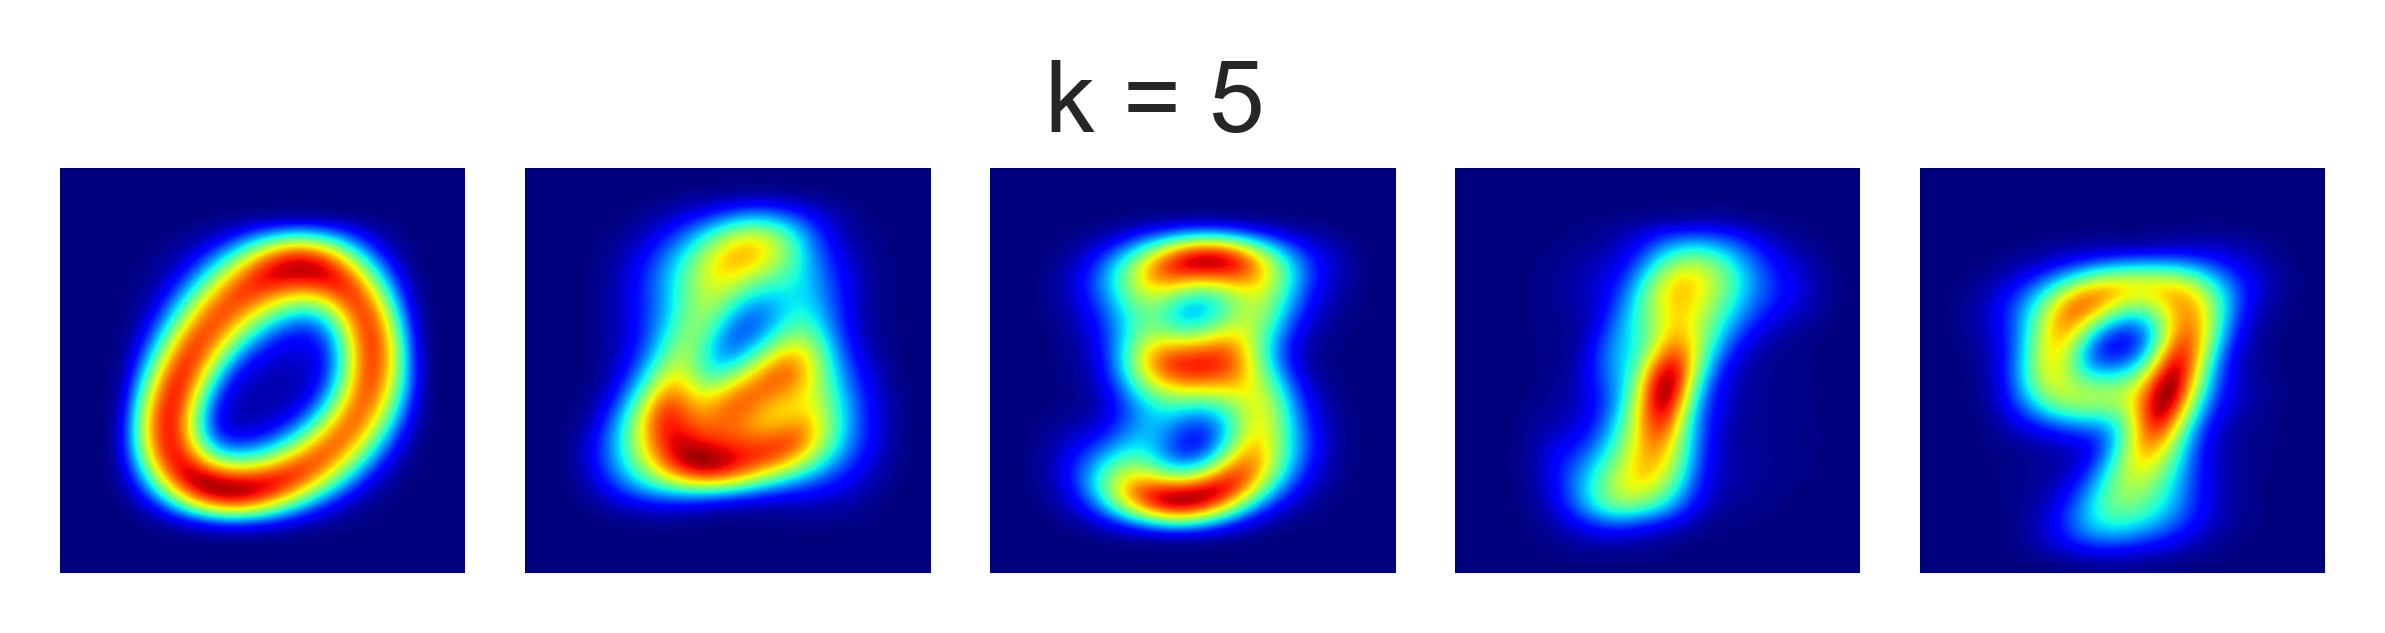

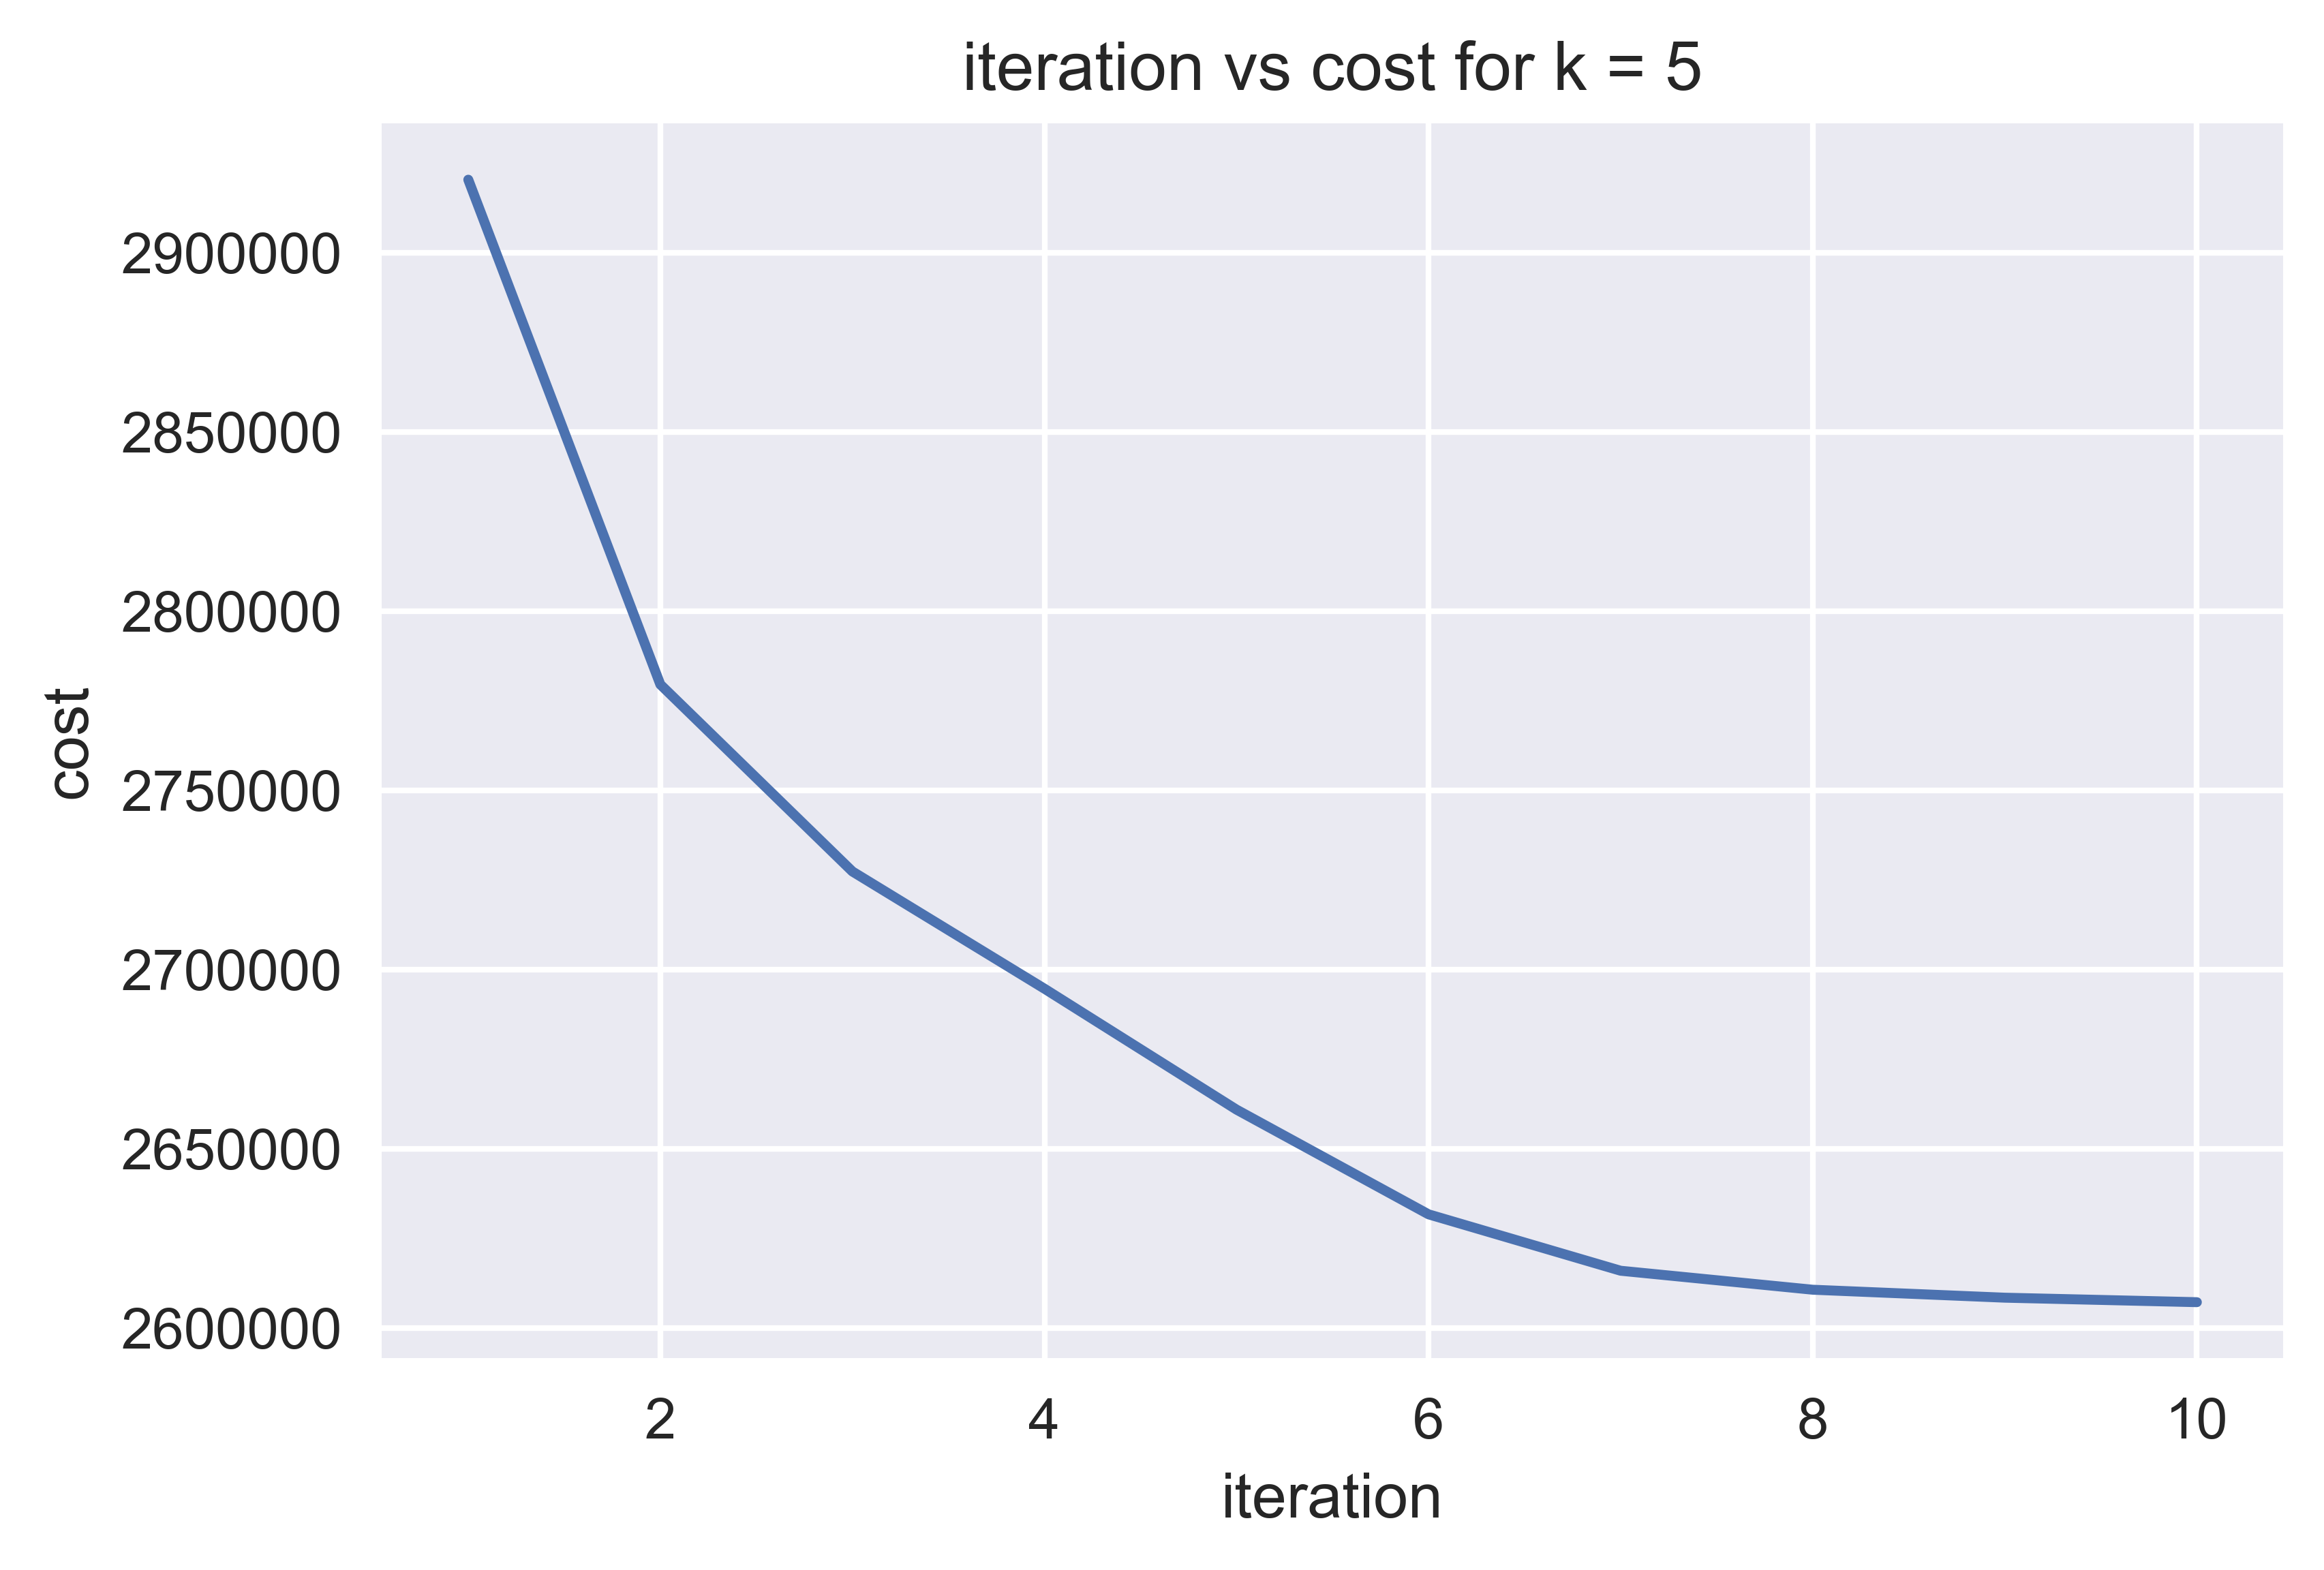

In [48]:
centroids,cost_vec,iter_vec = run_k_means(5,x_train)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

Text(0.5,0.98,'k = 5')

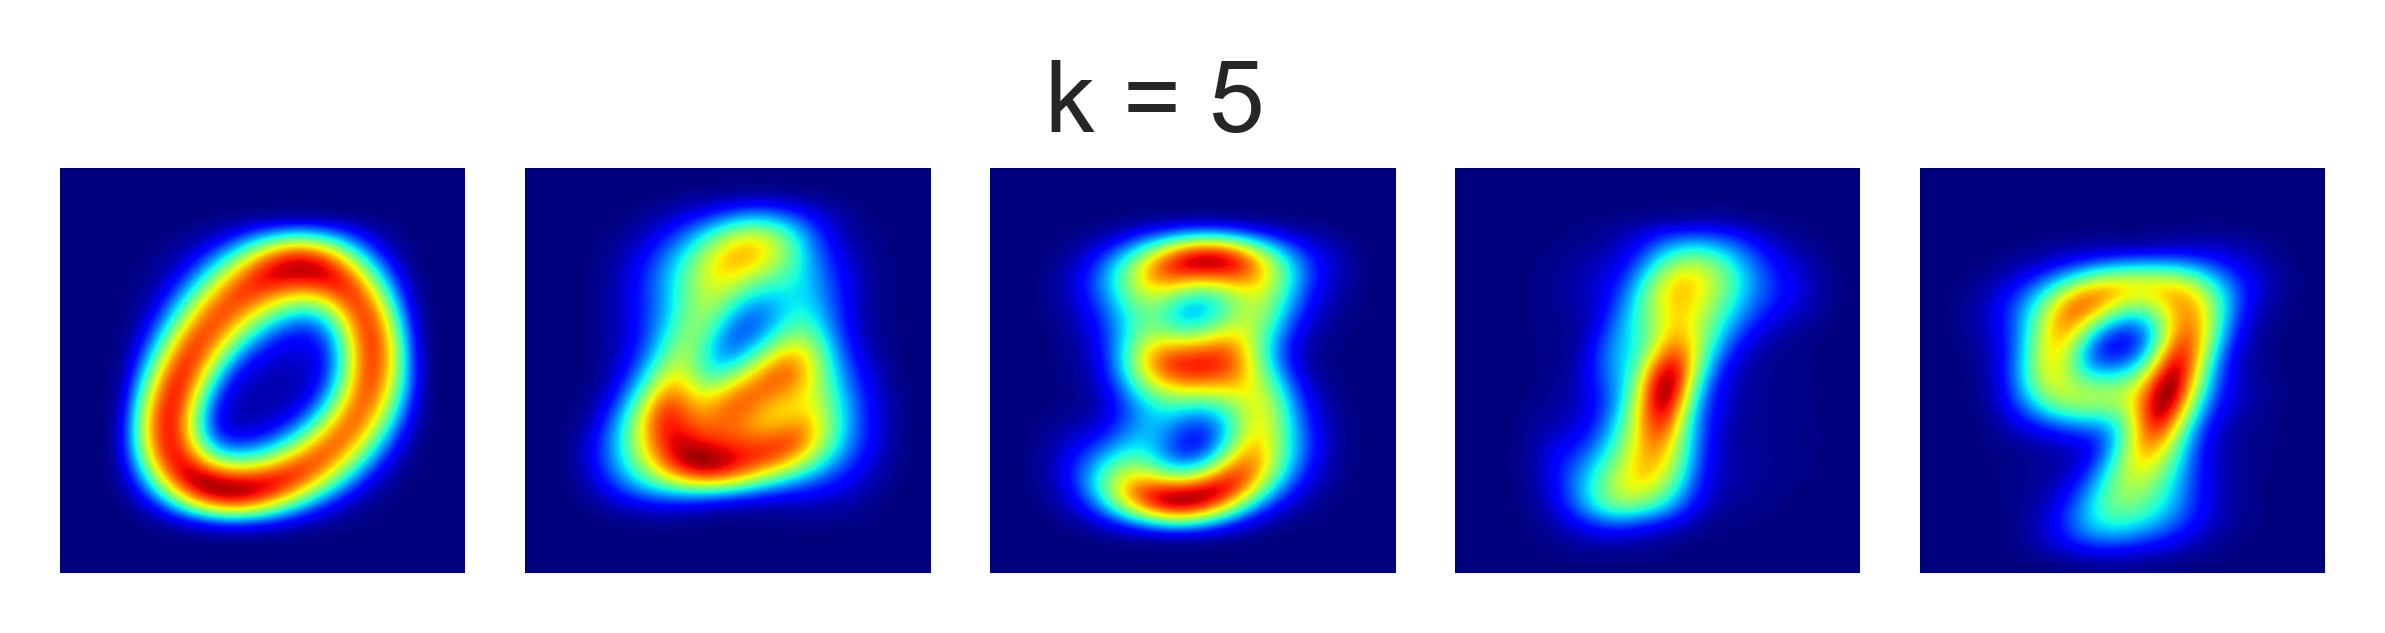

In [49]:
ncol = int(1)
nrow = int(centroids.shape[0])
k = nrow

fig = plt.figure(figsize = (nrow,ncol),dpi=600)
#fig = plt.figure()

#gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1], height_ratios=list(np.ones((centroids.shape[0],))),
#         wspace=0.5, hspace=0.5,
#        top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in np.arange(nrow):
    ax = plt.subplot(1,nrow,i+1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    interp_method = 'bicubic'
    single_image = np.reshape(np.nan_to_num(centroids[i,:]),[28,28])
    ax.imshow(single_image,interpolation=interp_method)
    plt.grid(False)
    plt.axis('off')

fig.suptitle('k = {}'.format(nrow))
fig.subplots_adjust(wspace=0, hspace=0,top=0.8)

plt.savefig('clusters_visualized_k_{}'.format(k))


Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Iteration number 6
Iteration number 7
Iteration number 8
Iteration number 9
Iteration number 10
Iteration number 11
Iteration number 12


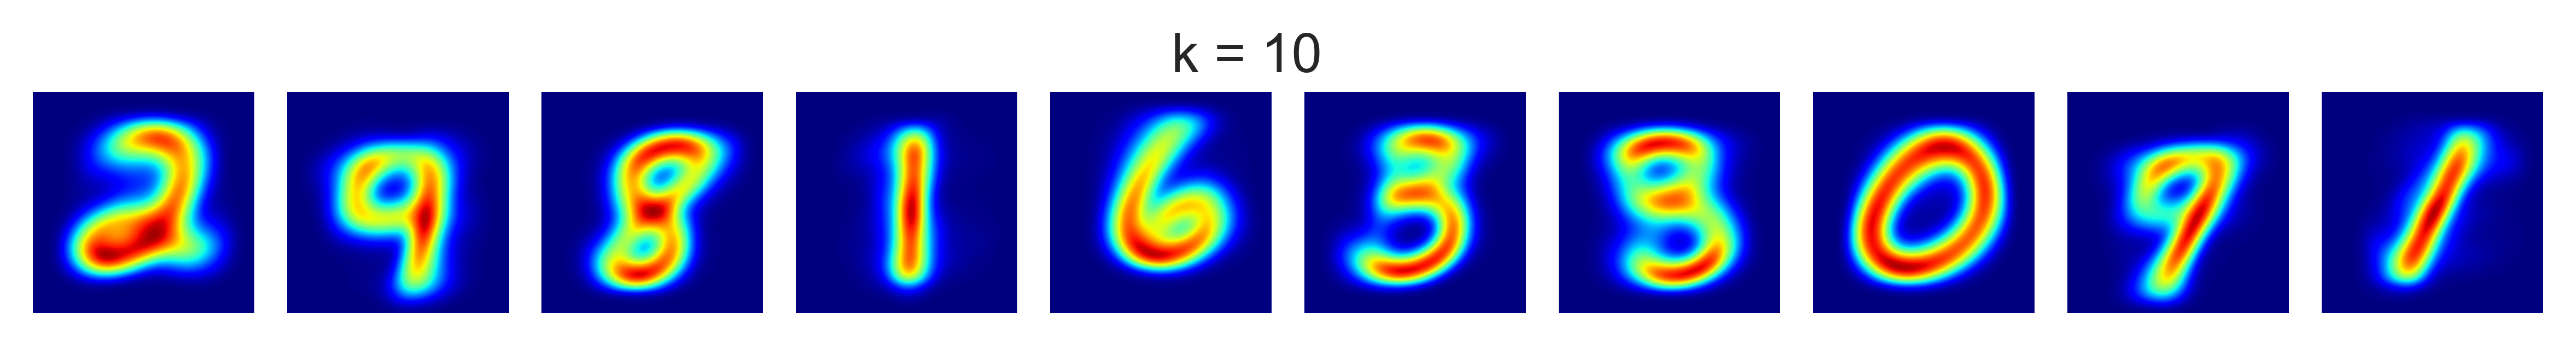

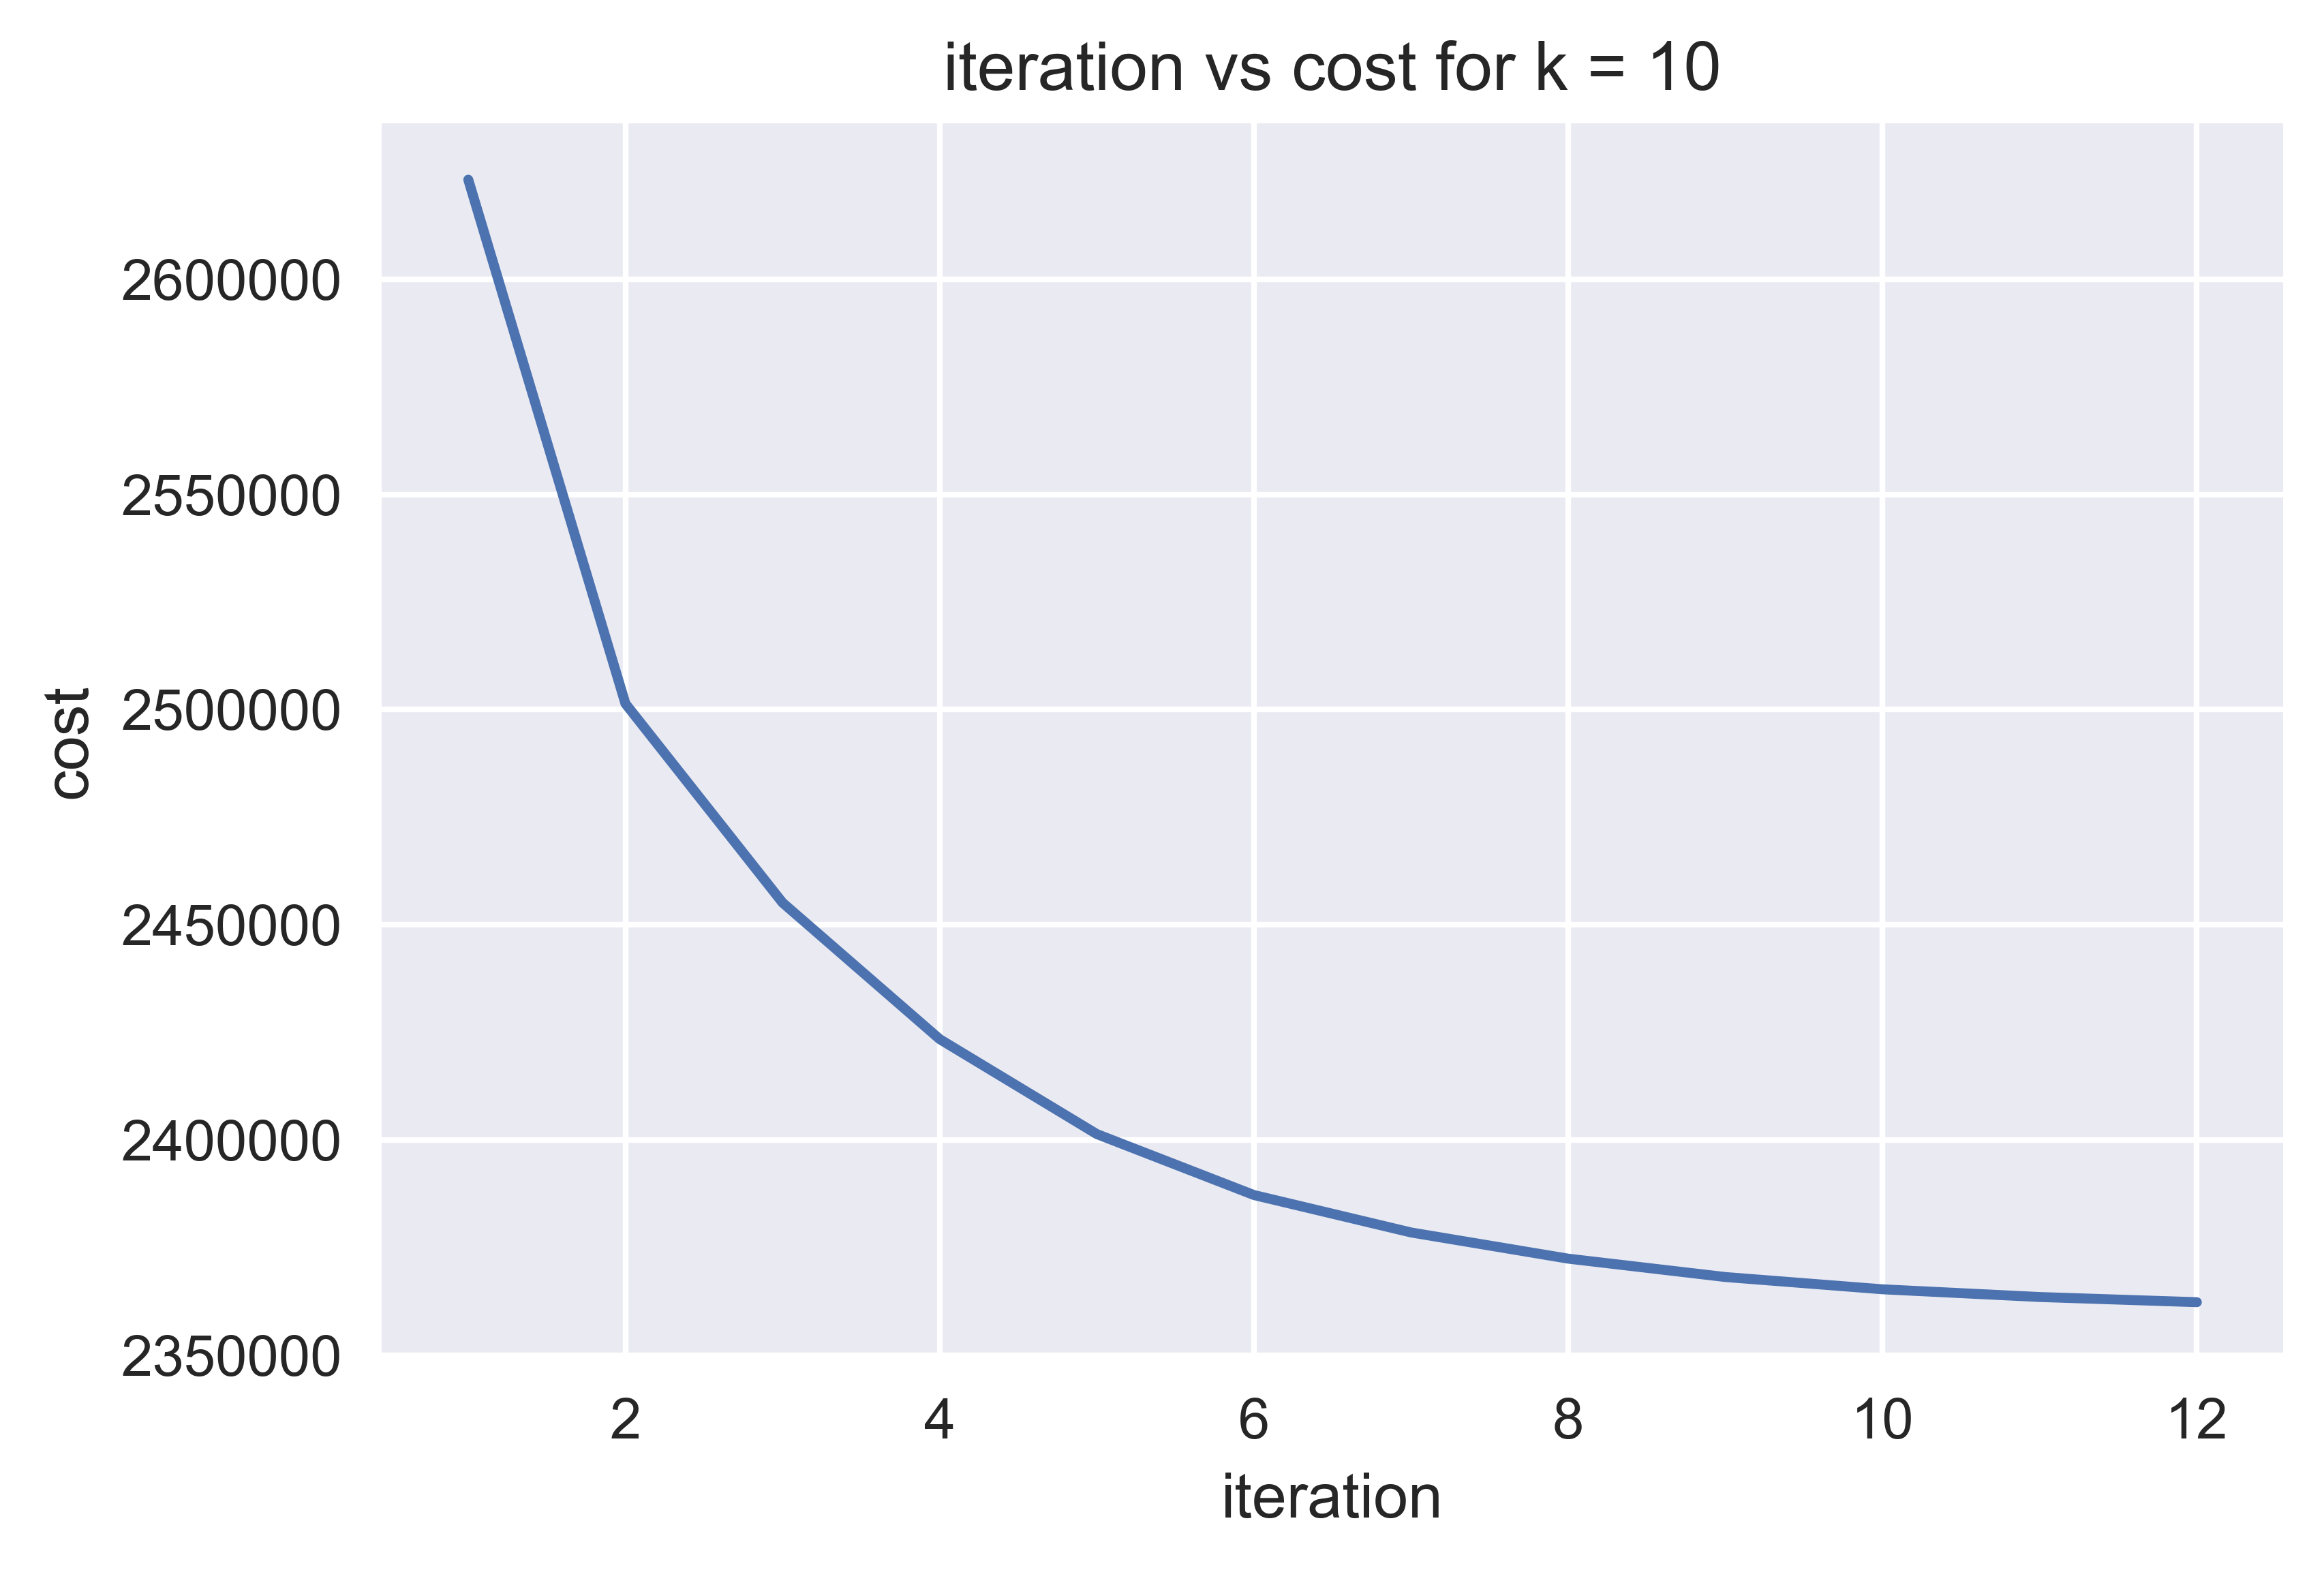

In [50]:
centroids,cost_vec,iter_vec = run_k_means(10,x_train)


[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

Text(0.5,0.98,'k = 10')

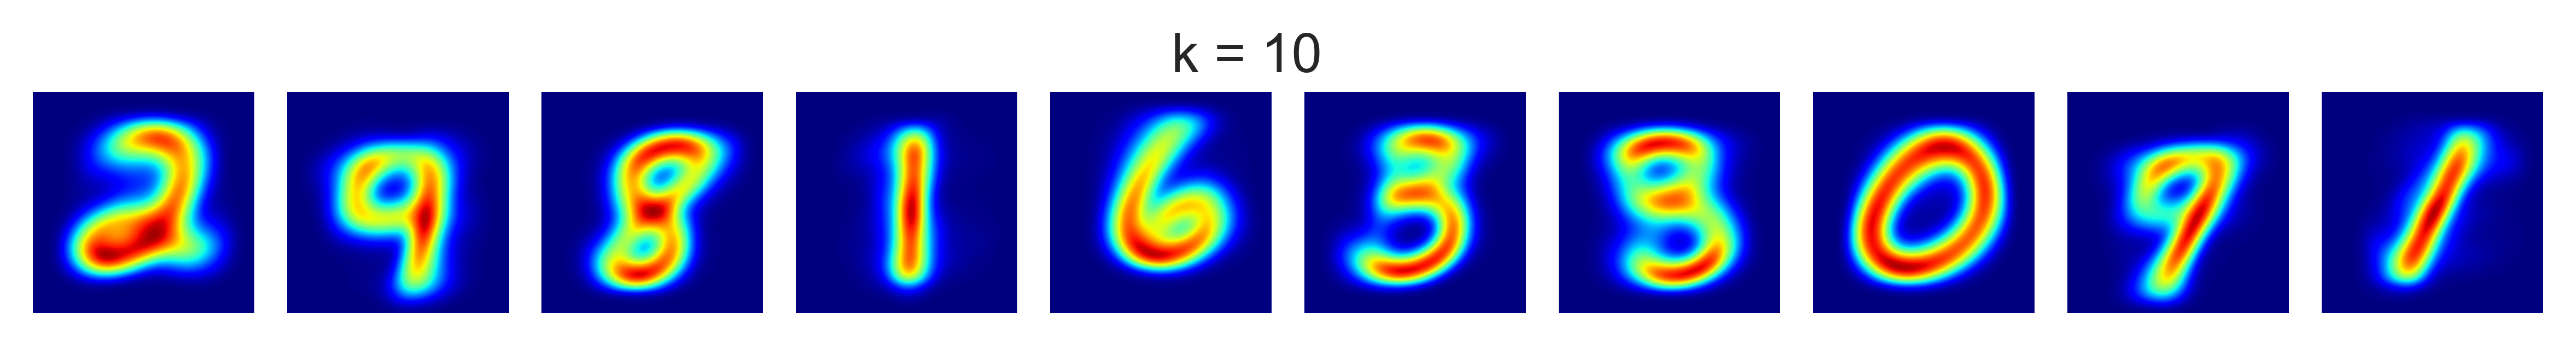

In [51]:
ncol = int(1)
nrow = int(centroids.shape[0])
k = nrow

fig = plt.figure(figsize = (nrow,ncol),dpi=600)
#fig = plt.figure()

#gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1], height_ratios=list(np.ones((centroids.shape[0],))),
#         wspace=0.5, hspace=0.5,
#        top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in np.arange(nrow):
    ax = plt.subplot(1,nrow,i+1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    interp_method = 'bicubic'
    single_image = np.reshape(np.nan_to_num(centroids[i,:]),[28,28])
    ax.imshow(single_image,interpolation=interp_method)
    plt.grid(False)
    plt.axis('off')

fig.suptitle('k = {}'.format(nrow))
fig.subplots_adjust(wspace=0, hspace=0,top=0.8)

plt.savefig('clusters_visualized_k_{}'.format(k))





Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Iteration number 5
Iteration number 6
Iteration number 7
Iteration number 8
Iteration number 9
Iteration number 10
Iteration number 11
Iteration number 12
Iteration number 13
Iteration number 14
Iteration number 15
Iteration number 16


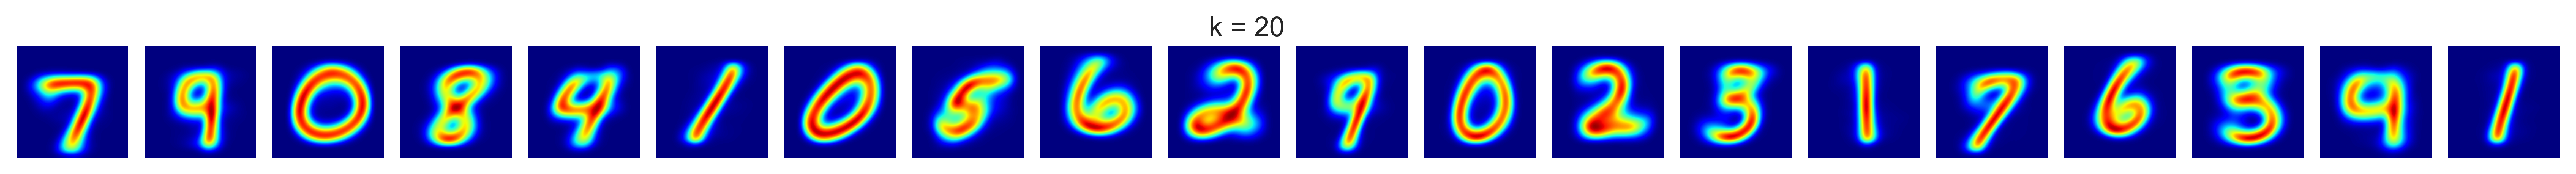

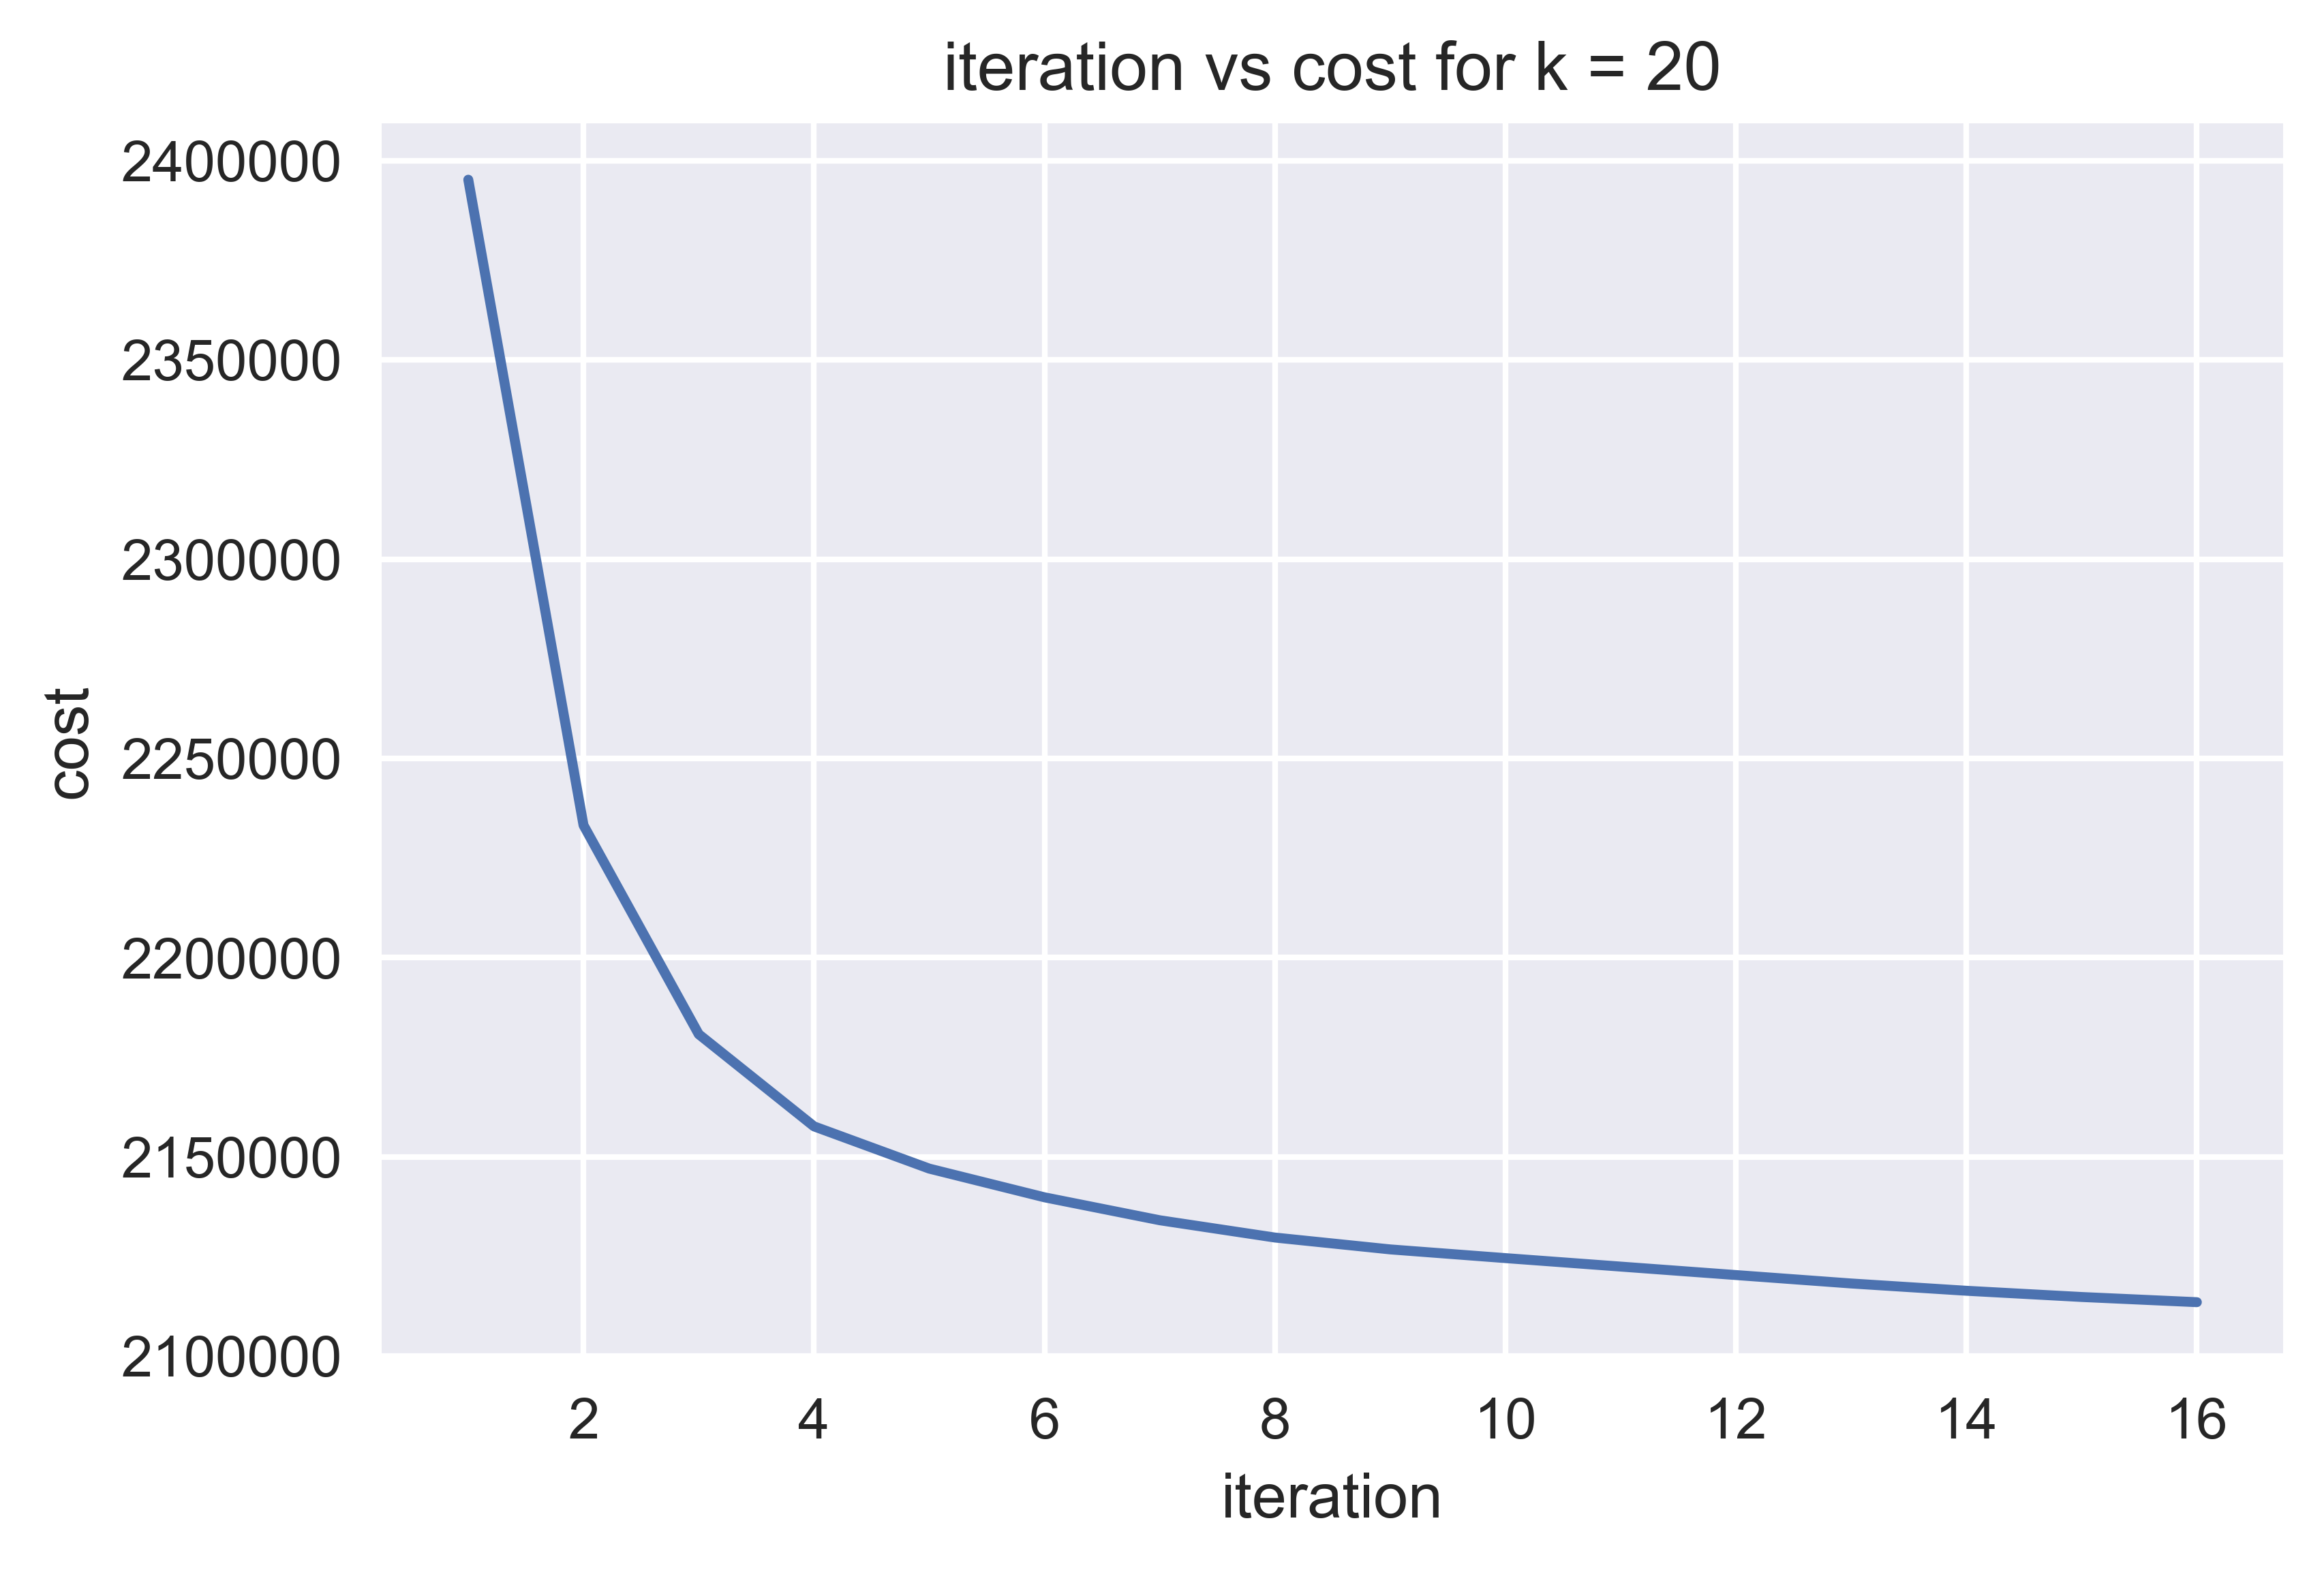

In [52]:
centroids,cost_vec,iter_vec = run_k_means(20,x_train)



[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

[]

[]

(-0.5, 27.5, 27.5, -0.5)

Text(0.5,0.98,'k = 20')

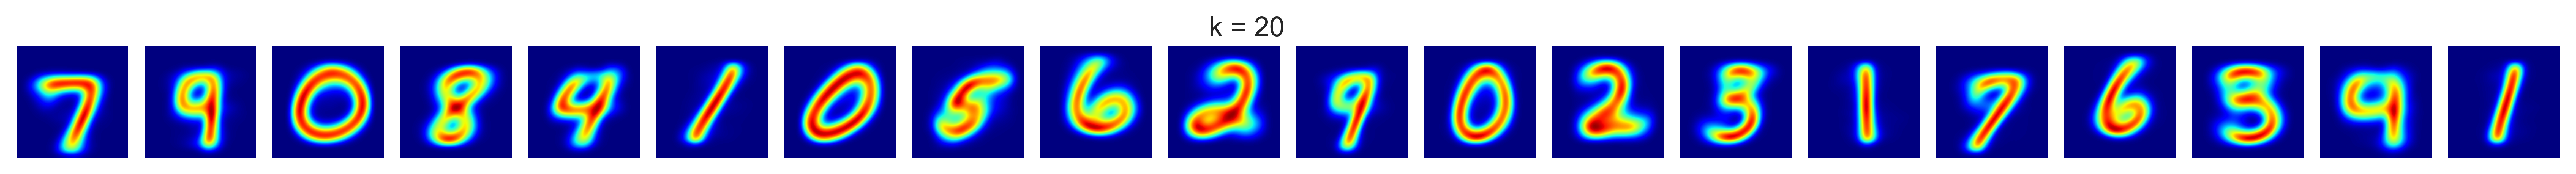

In [53]:
ncol = int(1)
nrow = int(centroids.shape[0])
k = nrow

fig = plt.figure(figsize = (nrow,ncol),dpi=600)
#fig = plt.figure()

#gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1], height_ratios=list(np.ones((centroids.shape[0],))),
#         wspace=0.5, hspace=0.5,
#        top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in np.arange(nrow):
    ax = plt.subplot(1,nrow,i+1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    interp_method = 'bicubic'
    single_image = np.reshape(np.nan_to_num(centroids[i,:]),[28,28])
    ax.imshow(single_image,interpolation=interp_method)
    plt.grid(False)
    plt.axis('off')

fig.suptitle('k = {}'.format(nrow))
fig.subplots_adjust(wspace=0, hspace=0,top=0.8)

plt.savefig('clusters_visualized_k_{}'.format(k))



